In [1]:
import raccoon_ipm as rp
import numpy as np
import yaml
import scipy.stats as stats
import macroeco.models as md
reload(rp)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
md.nbinom.pmf(range(10), mu=3, k_agg=1)

array([ 0.25      ,  0.1875    ,  0.140625  ,  0.10546875,  0.07910156,
        0.05932617,  0.04449463,  0.03337097,  0.02502823,  0.01877117])

In [33]:
rp.nbinom_pmf(3, mu=3, k=1)

array([ 0.10546875])

In [95]:
worms = np.arange(-100, 100)
inds = worms >= 0
worm_vects = [np.array([x]) for x in worms[~inds]] + \
                                    [np.arange(x + 1) for x in worms[inds]]

In [96]:
worm_vects

[array([-100]),
 array([-99]),
 array([-98]),
 array([-97]),
 array([-96]),
 array([-95]),
 array([-94]),
 array([-93]),
 array([-92]),
 array([-91]),
 array([-90]),
 array([-89]),
 array([-88]),
 array([-87]),
 array([-86]),
 array([-85]),
 array([-84]),
 array([-83]),
 array([-82]),
 array([-81]),
 array([-80]),
 array([-79]),
 array([-78]),
 array([-77]),
 array([-76]),
 array([-75]),
 array([-74]),
 array([-73]),
 array([-72]),
 array([-71]),
 array([-70]),
 array([-69]),
 array([-68]),
 array([-67]),
 array([-66]),
 array([-65]),
 array([-64]),
 array([-63]),
 array([-62]),
 array([-61]),
 array([-60]),
 array([-59]),
 array([-58]),
 array([-57]),
 array([-56]),
 array([-55]),
 array([-54]),
 array([-53]),
 array([-52]),
 array([-51]),
 array([-50]),
 array([-49]),
 array([-48]),
 array([-47]),
 array([-46]),
 array([-45]),
 array([-44]),
 array([-43]),
 array([-42]),
 array([-41]),
 array([-40]),
 array([-39]),
 array([-38]),
 array([-37]),
 array([-36]),
 array([-35]),
 array([-

In [5]:
with open('ipm_params.yml') as f:
    # use safe_load instead load
    params = yaml.safe_load(f)

In [43]:
reload(rp)
age_struct = np.array([40, 5])
res = rp.full_R0(params, age_struct)

In [44]:
print(res[0])

[[ 123650.14229095       0.               0.               0.        ]
 [      0.           62979.18357542       0.               0.        ]
 [      0.               0.          123650.14229095       0.        ]
 [      0.               0.               0.           62979.18357542]]


In [45]:
print(res[1])

[[ 123650.14229095       0.        ]
 [      0.           62979.18357542]]


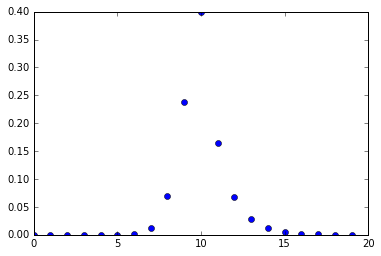

In [76]:
plot([rp._growth_fxn(x, 10, 10, 100000, params) for x in range(20)], 'o')

In [77]:
np.sum([rp._growth_fxn(x, 10, 10, 100000, params) for x in range(20)])

0.99990645717774962

In [65]:
a = np.linspace(-2, 2, num=5)
inds = a >= 0
b = [np.array([x]) for x in a[~inds]] + [np.arange(x + 1) for x in a[inds]]

In [69]:
b[0][::-1]

array([-2.])

In [43]:
rp.nbinom_pmf(0, mu=0, k=1)

array([ 1.])

## Making the Growth Matrix

Trying out different ways to make the growth matrix to increase speed

In [3]:
reload(rp)
min_load = 0
max_load = 100

In [7]:
%%time
# Use nested list comprehension
gmat1 = np.array([[rp._growth_fxn(next_load, current_load, 5, 10000, params) for next_load in range(max_load + 1)] for current_load in range(max_load + 1)])

CPU times: user 4.04 s, sys: 14.2 ms, total: 4.05 s
Wall time: 4.06 s


In [23]:
np.r_[np.array([0]*2), np.array([2]*2)]

array([0, 0, 2, 2])

In [30]:
type(gmat2)

numpy.ndarray

In [6]:
# Try vectorization via meshgrid
nxt, cur = np.meshgrid(range(101), range(101))
samps = len(nxt.ravel())

In [25]:
from functools import partial

# COOL!  Make a partial growth function
partial_growth = partial(rp._growth_fxn, params=params)

In [27]:
%%time
gmat2 = np.reshape(map(partial_growth, nxt.ravel(), 
                                       cur.ravel(), 
                                       np.repeat(0, samps), np.repeat(10000, samps)),
                                       (len(nxt), len(nxt)))

CPU times: user 1.9 s, sys: 8.49 ms, total: 1.91 s
Wall time: 1.91 s


In [32]:
np.all(gmat1 == gmat2)

True

In [40]:
%%time
gmat3_temp = rp.growth_fxn(nxt, cur, 5, 10000, params)

CPU times: user 3.27 s, sys: 17.8 ms, total: 3.29 s
Wall time: 3.31 s


In [33]:
101 * 101

10201

In [31]:
np.all(gmat3 == gmat3_temp)

True

In [27]:
np.all(gmat1 == gmat3)

NameError: name 'gmat1' is not defined

In [29]:
reload(rp)
import cProfile
cProfile.run('rp.growth_fxn(nxt, cur, 5, 10000, params)') # Transpose for correct dimensions

         2110059 function calls in 3.825 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.825    3.825 <string>:1(<module>)
    20404    0.035    0.000    0.399    0.000 _discrete_distns.py:163(_pmf)
    20404    0.364    0.000    0.364    0.000 _discrete_distns.py:166(_logpmf)
    10202    0.220    0.000    0.220    0.000 _discrete_distns.py:46(_logpmf)
    10202    0.020    0.000    0.240    0.000 _discrete_distns.py:51(_pmf)
   358754    0.112    0.000    0.771    0.000 _methods.py:31(_sum)
   358754    0.350    0.000    1.234    0.000 fromnumeric.py:1737(sum)
        1    0.000    0.000    3.825    3.825 function_base.py:1783(__call__)
        1    0.000    0.000    0.000    0.000 function_base.py:1813(_get_ufunc_and_otypes)
        1    0.013    0.013    3.825    3.825 function_base.py:1869(_vectorize_call)
        6    0.000    0.000    0.000    0.000 numeric.py:406(asarray)
    30606  

In [34]:
import ipyparallel as ipp
rc = ipp.Client()
dv = rc[:]

# Import the necessary modules
with dv.sync_imports():
    import numpy
    import raccoon_ipm

importing numpy on engine(s)
importing raccoon_ipm on engine(s)


In [35]:
dv.push(dict(nxt=nxt.ravel(), cur=cur.ravel(), params=params))

<AsyncResult: _push>

In [38]:
%%time
dv.scatter('dt', zip(nxt.ravel(), cur.ravel()))
%px gmat4 = [raccoon_ipm._growth_fxn(tnxt, tcur, 40, 10000, params) for tnxt, tcur in dt]
gmat4 = np.reshape(dv.gather('gmat4').get(), (len(nxt), len(nxt)))

CPU times: user 171 ms, sys: 15.4 ms, total: 186 ms
Wall time: 1.87 s


In [48]:
((3.36 * 100) / 16) / 60.

0.35

In [51]:
np.all(gmat4 == gmat3)

True

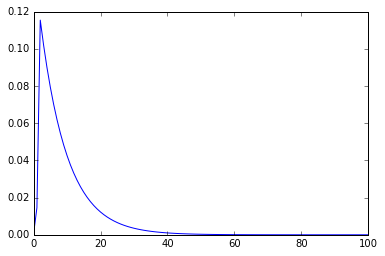

In [80]:
plot(gmat4[2, :])

In [91]:
np.sum(gmat4[2, :])

0.99999568566781605

In [52]:
%%time
dv.scatter('dt', zip(nxt.ravel(), cur.ravel()))
%px gmat4 = [raccoon_ipm._growth_fxn(tnxt, tcur, 0, 10000, params) for tnxt, tcur in dt]
gmat4 = np.reshape(dv.gather('gmat4').get(), (len(nxt), len(nxt)))

CPU times: user 123 ms, sys: 30.6 ms, total: 153 ms
Wall time: 2.47 s


In [58]:
%%time
dv.scatter('dt', zip(nxt.ravel(), cur.ravel()))
%px gmat4 = [raccoon_ipm._growth_fxn(tnxt, tcur, 0, 10000, params) for tnxt, tcur in dt]
gmat4 = np.reshape(dv.gather('gmat4').get(), (len(nxt), len(nxt)))

CPU times: user 168 ms, sys: 30.2 ms, total: 198 ms
Wall time: 1.41 s


In [64]:
%%time
dv.scatter('dt', zip(nxt.ravel(), cur.ravel()))
%px gmat4 = [raccoon_ipm._growth_fxn(tnxt, tcur, 0, 10000, params) for tnxt, tcur in dt]
gmat4 = np.reshape(dv.gather('gmat4').get(), (len(nxt), len(nxt)))

CPU times: user 164 ms, sys: 30.6 ms, total: 195 ms
Wall time: 1.41 s


In [98]:
%%time
dv.scatter('dt', zip(nxt.ravel(), cur.ravel()))
%px gmat4 = [raccoon_ipm._growth_fxn(tnxt, tcur, 20, 10000, params) for tnxt, tcur in dt]
gmat4 = np.reshape(dv.gather('gmat4').get(), (len(nxt), len(nxt)))

CPU times: user 224 ms, sys: 23.5 ms, total: 247 ms
Wall time: 2.39 s


In [69]:
with dv.sync_imports():
    import raccoon_ipm as rp

importing raccoon_ipm on engine(s)


In [66]:
@dv.parallel(block=True)
def growth_para(next_load, current_load, age, eggs, params):
    return(rp._growth_fxn(next_load, current_load, age, eggs, params))

In [67]:
%%time
gmat3 = growth_para.map(nxt.ravel(), cur.ravel(), 
                        np.repeat(0, samps), np.repeat(10000, samps), 
                        [params for i in range(samps)])

CompositeError: one or more exceptions from call to method: growth_para
[0:apply]: NameError: global name 'rp' is not defined
[1:apply]: NameError: global name 'rp' is not defined
[2:apply]: NameError: global name 'rp' is not defined
[3:apply]: NameError: global name 'rp' is not defined

In [63]:
def myfxn(x, **kwargs):
    print(kwargs)

In [65]:
myfxn(4, **params)

{'larval_infect': 0.25, 'death_thresh': 22, 'k_rodent': 1, 'egg_contact': 0.04, 'worm_death_rate': 0.066666666, 'age_immunity': 10000, 'patho': -4.2, 'resist': 0.03, 'random_death': 0.002509430066318874, 'age_resistance': 4, 'infect': 0.02, 'k_latrine': 1, 'baby_death': 0.089, 'mean_rodent': 3.49, 'old_death': 1.736111111111111e-05}


In [99]:
# Make transition matrix
surv_vect = rp.survival_fxn(20, np.arange(max_load + 1), params)

Pmat = np.dot(np.diag(surv_vect), gmat4).T

In [100]:
Pmat

array([[  5.83370761e-001,   3.76233387e-002,   2.42644246e-003, ...,
          1.17476884e-117,   7.55593285e-119,   4.85946910e-120],
       [  2.39807297e-001,   5.61213315e-001,   7.13912329e-002, ...,
          1.67046901e-114,   1.08538032e-115,   7.05092736e-117],
       [  9.85780292e-002,   2.30698995e-001,   5.39897438e-001, ...,
          1.17555435e-111,   7.71683569e-113,   5.06420614e-114],
       ..., 
       [  8.50908488e-039,   1.99135380e-038,   4.66030125e-038, ...,
          1.22934725e-002,   2.68880063e-002,   5.12627523e-002],
       [  3.49784526e-039,   8.18589490e-039,   1.91571865e-038, ...,
          5.05350046e-003,   1.17945365e-002,   2.58423666e-002],
       [  1.43786572e-039,   3.36499095e-039,   7.87498009e-039, ...,
          2.07735178e-003,   4.84840191e-003,   1.13149398e-002]])

In [101]:
N = np.array([20] + 100*[0])
for i in range(100):
    N = np.dot(Pmat, N)

In [102]:
np.sum((N / sum(N)) * range(101))

10.807972638984232

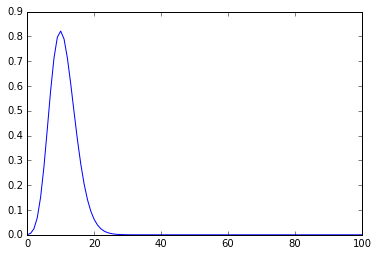

In [103]:
plot(N)

In [108]:
a = np.arange(25).reshape(5,5)
b = np.arange(5)
c = np.arange(6).reshape(2,3)

In [127]:
np.einsum(a, [1])

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

In [132]:
np.sum(b*b)

30

In [133]:
A = np.array([0, 1, 2])

B = np.array([[ 0,  1,  2,  3],
              [ 4,  5,  6,  7],
              [ 8,  9, 10, 11]])

In [137]:
(A[:, np.newaxis] * B).sum(axis=1)

array([ 0, 22, 76])

In [158]:
A = array([[1, 1, 1],
           [2, 2, 2],
           [5, 5, 5]])

B = array([[0, 1, 0],
           [1, 1, 0],
           [1, 1, 1]])

In [164]:
np.einsum('', A)

24

In [144]:
np.einsum("ij, jk -> ijk", A, B)

array([[[0, 1, 0],
        [1, 1, 0],
        [1, 1, 1]],

       [[0, 2, 0],
        [2, 2, 0],
        [2, 2, 2]],

       [[0, 5, 0],
        [5, 5, 0],
        [5, 5, 5]]])

In [142]:
np.einsum("ij, jk -> ik", A, B)

array([[ 2,  3,  1],
       [ 4,  6,  2],
       [10, 15,  5]])

In [146]:
np.einsum('ij, ij -> ij', A, B)

array([[0, 1, 0],
       [2, 2, 0],
       [5, 5, 5]])

In [150]:
np.einsum('ij, ij -> i', A, B)

array([ 1,  4, 15])

In [152]:
A = np.arange(10)
B = np.arange(5, 15)

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [157]:
np.einsum("i, j -> ij", A, B)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  5,   6,   7,   8,   9,  10,  11,  12,  13,  14],
       [ 10,  12,  14,  16,  18,  20,  22,  24,  26,  28],
       [ 15,  18,  21,  24,  27,  30,  33,  36,  39,  42],
       [ 20,  24,  28,  32,  36,  40,  44,  48,  52,  56],
       [ 25,  30,  35,  40,  45,  50,  55,  60,  65,  70],
       [ 30,  36,  42,  48,  54,  60,  66,  72,  78,  84],
       [ 35,  42,  49,  56,  63,  70,  77,  84,  91,  98],
       [ 40,  48,  56,  64,  72,  80,  88,  96, 104, 112],
       [ 45,  54,  63,  72,  81,  90,  99, 108, 117, 126]])

In [112]:
%%time
np.dot(a, b)

CPU times: user 18 µs, sys: 6 µs, total: 24 µs
Wall time: 26 µs


array([ 30,  80, 130, 180, 230])

In [88]:
next_load = 0
current_load = 3
diff = next_load - current_load
worms_lost = np.arange(current_load + 1)

In [89]:
worms_lost

array([0, 1, 2, 3])

In [105]:
20*12*2 / 60.

8.0

In [158]:
rp.md.nbinom.pmf(np.arange(30000), 200, 0.5)

array([  4.99376169e-02,   2.49065421e-02,   1.86333233e-02, ...,
         4.82088235e-37,   4.80878005e-37,   4.79670813e-37])

In [112]:
(np.array([0, 3, 4, 5]) == 0).astype(np.int)

array([1, 0, 0, 0])

In [96]:
rp.md.nbinom.pmf(-3, mu=2, k_agg=1)

0.0

In [106]:
np.einsum?

In [134]:
?np.arange

In [159]:
reload(rp)

<module 'raccoon_ipm' from 'raccoon_ipm.py'>

In [155]:
worms = np.array([-3, -2, -1, 0, 1, 2, 3])
rp._worms_gained(worms, 0.02, 1, 100)

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         9.52380952e-01,   4.53514739e-02,   2.15959400e-03,
         1.02837809e-04])

In [149]:
rp._worms_gained(6, params, 10000, 5, 4)

0.005465624975182326

In [152]:
a = np.nan_to_num([np.nan, np.nan, 2])

In [79]:
np.int(3 == 0)

0

In [184]:
%timeit stats.nbinom.pmf(range(2000000), n=1, p=(1. / (200 + 1)))

1 loops, best of 3: 482 ms per loop


In [185]:
%timeit rp.md.nbinom.pmf(range(2000000), mu=200, k_agg=1)

1 loops, best of 3: 498 ms per loop


In [191]:
a = stats.nbinom.pmf(range(200000), n=1, p=(1. / (200 + 1)))

In [190]:
b = rp.md.nbinom.pmf(range(200000), mu=200, k_agg=1)

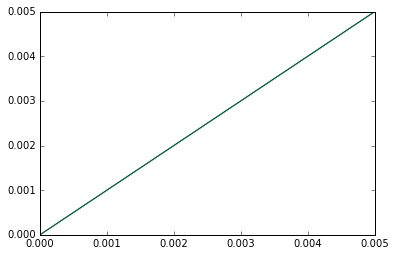

In [195]:
plot(a, b)
plot(a, a)

In [16]:
(20 * 12) / 60

4

In [36]:
num_ages = 20*12
surv_vals = [rp.survival_fxn(age, 0, params) for age in np.arange(num_ages)]
L = np.diag(surv_vals, k=-1)

In [37]:
L[240, :]

array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    

In [29]:
np.diag(surv_vals, k=-1).shape

(242, 242)

In [222]:
reload(rp)
rp.reproduction_fxn(13, 500, params)

0.44626032029685964

In [220]:
rp.get_repro_matrix(params, 500)

array([[ 0.        ,  0.        ,  0.        , ...,  0.44626032,
         0.44626032,  0.44626032],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [269]:
r.close()

NameError: name 'r' is not defined

In [264]:
reload(rp)
with open('ipm_params.yml') as f:
    # use safe_load instead load
    params = yaml.safe_load(f)

months = 500
n_up = np.array([50] + [0]*239)
S_week = rp.get_survival_matrix(params)
S_month = np.linalg.matrix_power(S_week, 4)
res = np.empty((240, months + 1))
res[:, 0] = n_up

for i in np.arange(months):
    
    pop_size = np.sum(res[:, i])
    F = rp.get_repro_matrix(params, pop_size)
    res[:, i + 1] = np.dot(np.dot(F, S_month), res[:, i])
    
    

In [265]:
res[:, 9]

array([  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,  31.460014,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.   

In [266]:
S_week

array([[  9.08713909e-01,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   9.97490570e-01,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   9.97490569e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          8.33098733e-05,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   6.82227322e-05,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   5.56789643e-05]])

(-3, 250)

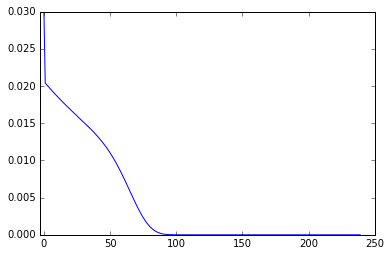

In [267]:
plot(res[:, -1] / np.sum(res[:, -1]))
plt.xlim(-3, 250)

(0, 1)

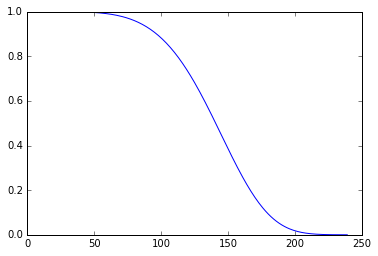

In [263]:
age = np.arange(240)
plot(age, np.exp(-10*(age / 240.)**5))
plt.ylim(0, 1)

(0, 1)

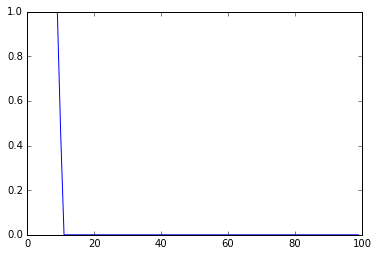

In [198]:
plot(stats.weibull_min.sf(np.linspace(0, 10, num=100), 9, 100))
plt.ylim(0, 1)

In [153]:
probs = res[:, -1] / np.sum(res[:, -1])
np.sum(probs*np.arange(240))

75.53450761304498

In [156]:
75/12

6

In [157]:
200 / 12

16

In [20]:
reload(rp)

<module 'raccoon_ipm' from 'raccoon_ipm.py'>

In [21]:
with open('ipm_params.yml') as f:
    # use safe_load instead load
    params = yaml.safe_load(f)

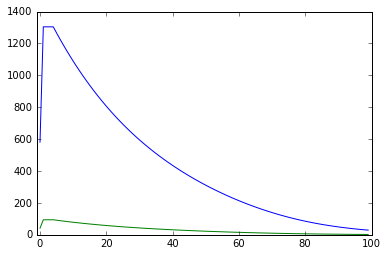

In [22]:
params['age_immunity'] = 0.03
params['age_resistance'] = 4
params['egg_contact'] = 0.003
R0_rel = rp.relative_R0(params)
plot(R0_rel)
plt.xlim(-1, 100)
params['egg_death_rate'] = 10
R0_rel = rp.relative_R0(params)
plot(R0_rel)

In [ ]:
params['egg_death_rate'] = 10

In [12]:
R0_rel

[581.68208405560142,
 1304.4371269031153,
 1304.4371198131503,
 1304.4370715556479,
 1304.4368929343229,
 0.059221321503406914,
 2.688641644203184e-06,
 1.2206394852558234e-10,
 5.5416791814680874e-15,
 2.515906863126364e-19,
 1.1422117477749666e-23,
 5.1855778061709188e-28,
 2.3542124498043456e-32,
 1.0687878515659993e-36,
 4.8521476758365556e-41,
 2.2027860787716286e-45,
 1.0000126333043491e-49,
 4.5397548651744267e-54,
 2.0608758425202232e-58,
 9.3554001119024961e-63,
 4.2468063178975496e-67,
 1.9277484454481392e-71,
 8.7503247916987172e-76,
 3.971748937301713e-80,
 1.8026894070557789e-84,
 8.181614748288913e-89,
 3.7130724993665493e-93,
 1.6850049494614278e-97,
 7.646084952503259e-102,
 3.4693159148525465e-106,
 1.5740253970049612e-110,
 7.1406690113935281e-115,
 3.2390766476740678e-119,
 1.4691100326311563e-123,
 6.6624439677950552e-128,
 3.0210232797265722e-132,
 1.3696534217431626e-136,
 6.2086619427830536e-141,
 2.8139112593919073e-145,
 1.2750932106154692e-149,
 5.776788560218